In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import matplotlib

import preprocessing
import train

In [435]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [436]:
M_data_2019_04_08 = preprocessing.Preprocessing('M_data_2019_04_08','/Users/cm/20190408/','home-assistant_v2.db')

In [437]:
rooms = ['schlafzimmer','kuche','wohnzimmer']

In [438]:
M_data_2019_04_08.load_data(rooms=rooms)

#### Extract weather data

In [439]:
M_data_2019_04_08.extract_weather_data()

#### Build X Frames weather data

In [440]:
M_data_2019_04_08.build_x_frame(rooms=rooms)

#### more data

In [443]:
M_data_2019_04_16 = preprocessing.Preprocessing('M_data_2019_04_16','/Users/cm/20190416/','home-assistant_v2.db')

In [444]:
rooms = ['schlafzimmer','kuche','wohnzimmer']

In [445]:
M_data_2019_04_16.load_data(rooms=rooms)

#### Extract weather data

In [446]:
M_data_2019_04_16.extract_weather_data()

#### Build X Frames weather data

In [447]:
M_data_2019_04_16.build_x_frame(rooms=rooms)

#### Test with one specific DataFrame

In [449]:
frame = M_data_2019_04_16.get('train_climatewohnzimmer')

In [213]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [502]:
end_date = np.datetime64('2020-04-08 23:59:00')
start_date = np.datetime64('2019-04-03 00:00:00')

In [451]:
frame2 = pd.DataFrame(min_max_scaler.fit_transform(frame.drop('last_updated', axis=1).astype(np.float64)),columns=list(frame.drop('last_updated', axis=1).columns)).astype(np.float32)

In [452]:
frame3 = frame[(frame['last_updated'] > start_date) & (frame['last_updated'] < end_date)]
frame4 = min_max_scaler.fit_transform(frame3.drop(columns=['last_updated','current_temp']).astype(np.float64)).astype(np.float32)

In [453]:
frame3 = frame[(frame['last_updated'] > start_date) & (frame['last_updated'] < end_date)]
frame4 = min_max_scaler.fit_transform(frame3.drop(columns=['last_updated','current_temp']).astype(np.float64)).astype(np.float32)

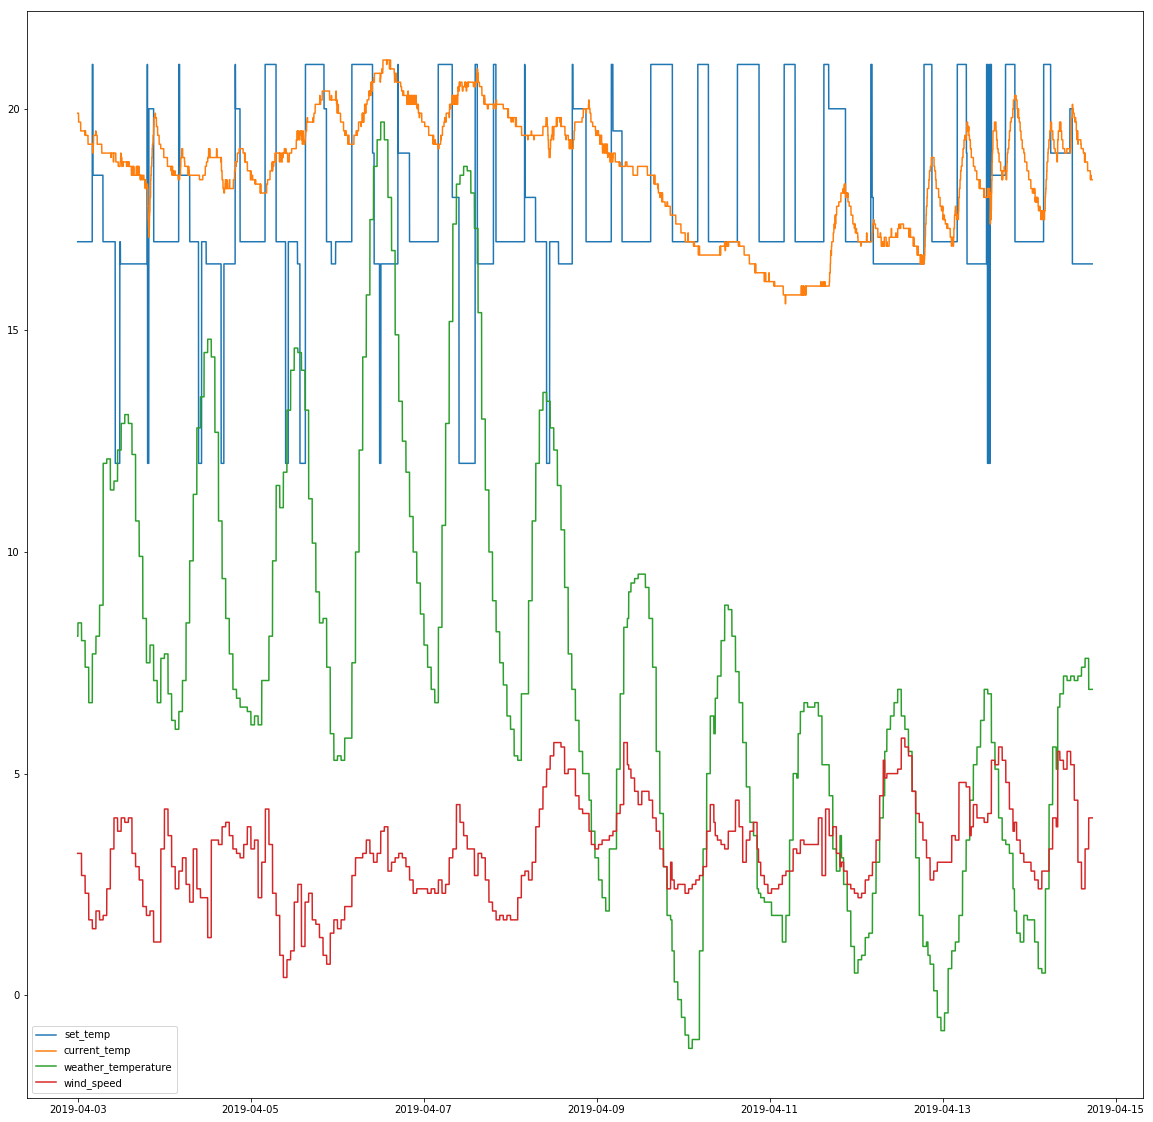

In [454]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,20])
plt.plot_date(dates, frame3['set_temp'], '-')
plt.plot_date(dates, frame3['current_temp'], '-')
plt.plot_date(dates, frame3['weather_temperature'], '-')
matplotlib.pyplot.plot_date(dates, frame3['wind_speed'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['wind_direction'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['humidity'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['cloudiness'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['pressure'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['dewpoint_temperature'], '-')
plt.legend()

In [455]:
train_set, val_set, test_set = train.train_val_test_split(frame, 0.2, 0.2)

In [456]:
X_train = train_set.drop(columns=['current_temp','last_updated'])
y_train = train_set['current_temp']
X_val = val_set.drop(columns=['current_temp','last_updated'])
y_val = val_set['current_temp']
X_test = test_set.drop(columns=['current_temp','last_updated'])
y_test = test_set['current_temp']

In [457]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

In [458]:
min_max_scaler.fit(X_train.astype(np.float64))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [459]:
X_train = min_max_scaler.transform(X_train).astype(np.float32)
X_val= min_max_scaler.transform(X_val).astype(np.float32)

In [460]:
X_train.shape

(30285, 17)

In [461]:
from sklearn.neighbors import KNeighborsRegressor

In [462]:
train_errors = []
test_errors = []
train_errors_val = []

for k in range(1,10):
    knn_iterated = KNeighborsRegressor(k)
    # Training
    knn_iterated.fit(X_train, y_train)
    
    # Predict
    y_k_predict = knn_iterated.predict(X_train)
    train_errors.append((1.0 * (y_train - y_k_predict)).mean())
                        
    y_k_predict_val = knn_iterated.predict(X_val)
    train_errors_val.append((1.0 * (y_val - y_k_predict_val)).mean())

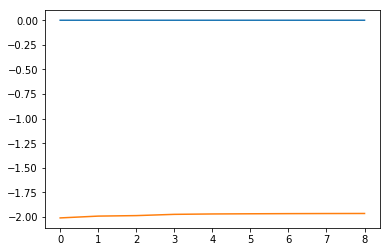

In [463]:
matplotlib.pyplot.plot(train_errors)
matplotlib.pyplot.plot(train_errors_val);

In [466]:
knn = sklearn.neighbors.KNeighborsRegressor(3)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(X_train)

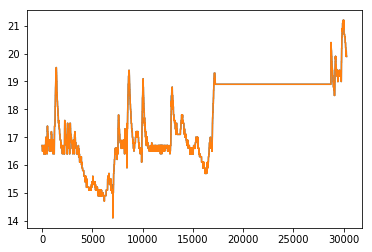

In [467]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(y_k_predict.reshape(y_k_predict.shape[0]));

In [468]:
D_in = X_train.shape[1]
D_out = 1
N = X_train.shape[0]

In [469]:
# Zufällige initialisierung der Gewichte
w = np.random.randn(D_in, D_out)

In [470]:
learning_rate = 1e-3

In [471]:
loss_hist = []
loss_hist_val = []
# Train
for t in range(100):
    # Berechne die Vorhersage
    y_pred = X_train.dot(w)
    y_pred_val = X_val.dot(w)
    y_pred = y_pred.reshape(y_pred.shape[0])
    y_pred_val = y_pred_val.reshape(y_pred_val.shape[0])
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    loss = np.square(y_pred - y_train).sum()
    loss_val = np.square(y_pred_val - y_val).sum()
    if t % 2 == 0:
        loss_hist.append(loss)
        loss_hist_val.append(loss_val)
        print(t, loss)

    # Berechne die Gradienten von w1 im Bezug auf den Fehler 
    grad_y_pred = 2.0 * (y_pred - y_train)
    grad_w = (1/N) * X_train.T.dot(grad_y_pred)

    # Aktualisiere die Gewichte mittels Gradienten Abstieg
    w -= learning_rate * grad_w.sum()

0 11285848.194018252
2 7692514.974755704
4 5293078.826874854
6 3690863.425059476
8 2620989.4898511413
10 1906584.7750161355
12 1429543.4341790017
14 1111000.6864309714
16 898294.8400890126
18 756261.2279980006
20 661418.7621675695
22 598088.0252217781
24 555799.1390463815
26 527560.8778133502
28 508704.8740359597
30 496113.8410570214
32 487706.22121623624
34 482092.06140064297
36 478343.2251031067
38 475839.95229874307
40 474168.40031948354
42 473052.2271183464
44 472306.9062247127
46 471809.220709668
48 471476.89288416243
50 471254.9820986025
52 471106.8019193687
54 471007.8551040422
56 470941.7837015519
58 470897.6647451948
60 470868.20446076535
62 470848.53245511657
64 470835.39653963794
66 470826.6250763441
68 470820.7679612889
70 470816.85689244897
72 470814.24528941093
74 470812.5014002834
76 470811.33692419523
78 470810.5593492115
80 470810.04012613645
82 470809.6934166779
84 470809.46190260537
86 470809.30730986357
88 470809.20408108126
90 470809.13515040965
92 470809.089122185

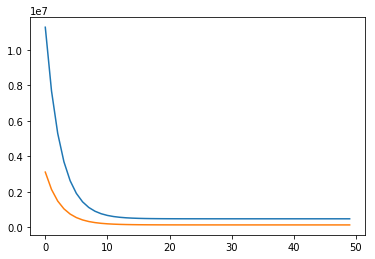

In [472]:
matplotlib.pyplot.plot(loss_hist)
matplotlib.pyplot.plot(loss_hist_val);

In [473]:
len(list(y_pred.reshape(y_pred.shape[0])))

30285

In [474]:
sklearn.metrics.mean_squared_error(list(y_train), list(y_pred.reshape(y_pred.shape[0])))

15.545947469816113

In [475]:
len(list(y_train))

30285

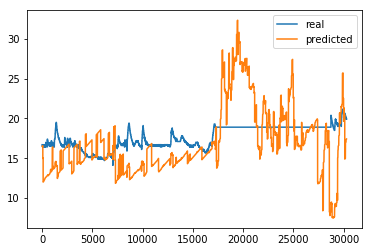

In [476]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(list(y_pred));
matplotlib.pyplot.legend(['real','predicted'])

In [477]:
#error = 
error = list(np.array(list(y_train)) - np.array(list(y_pred.reshape(y_pred.shape[0]))))

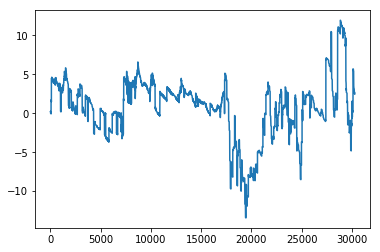

In [478]:
matplotlib.pyplot.plot(error);

In [479]:
knn = sklearn.neighbors.KNeighborsRegressor(10)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(frame4)
len(y_k_predict)

16891

In [480]:
len(frame4[:,1])

16891

In [481]:
(y_k_predict-frame3['current_temp']).mean()

0.06773252027706954

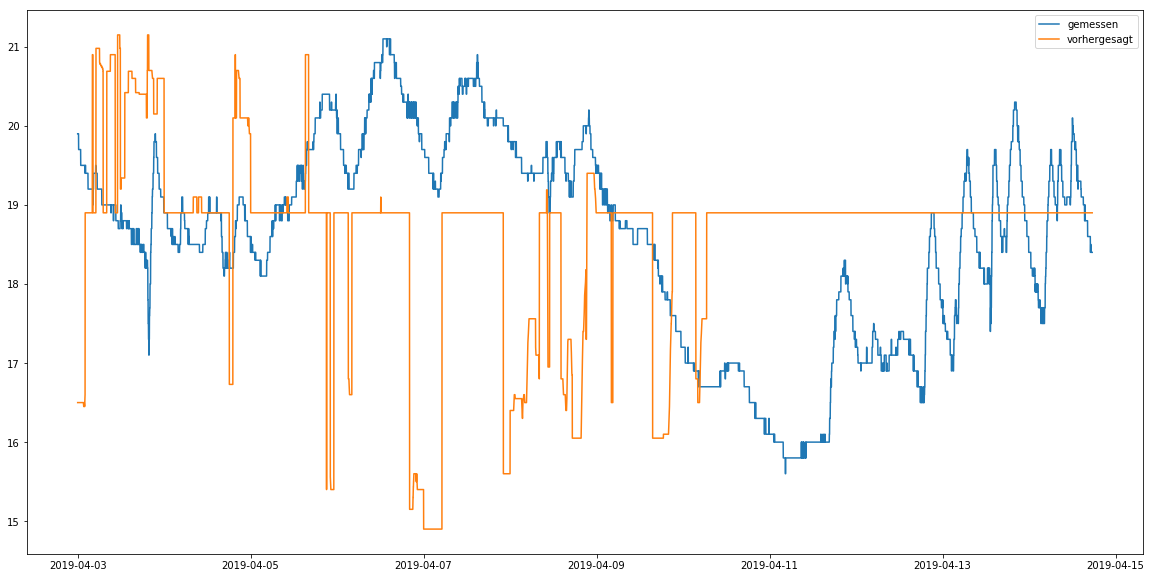

In [482]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_k_predict.reshape(y_k_predict.shape[0]),'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [483]:
from sklearn.tree import DecisionTreeRegressor

In [484]:
# Train the model using the training sets
error = []
error_val = []
error_test = []
probilities = pd.DataFrame()
proba_test = []
proba_train = []
proba_validate = []

for i in range(1, 50):
#Predict Output
    classifier = DecisionTreeRegressor(max_depth = i)
    classifier.fit(X_train,y_train)
    y_= classifier.predict(X_train)
    y_v = classifier.predict(X_val)
    y_t = classifier.predict(X_test)
    error.append(sklearn.metrics.mean_squared_error(y_train,y_))
    error_test.append(sklearn.metrics.mean_squared_error(y_test,y_t))
    error_val.append(sklearn.metrics.mean_squared_error(y_val,y_v))

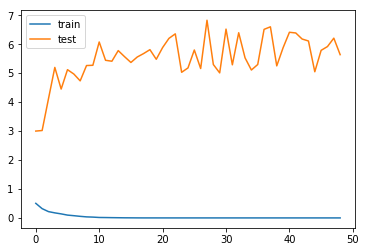

In [485]:
matplotlib.pyplot.plot(error)
#matplotlib.pyplot.plot(error_test)
matplotlib.pyplot.plot(error_val)
matplotlib.pyplot.legend(['train','test','val']);

In [486]:
dtr = DecisionTreeRegressor()#max_depth=28)
dtr.fit(X_train, y_train)
y_dtr_predict = dtr.predict(frame4)

In [487]:
(y_dtr_predict-frame3['current_temp']).mean()

0.15286839144961784

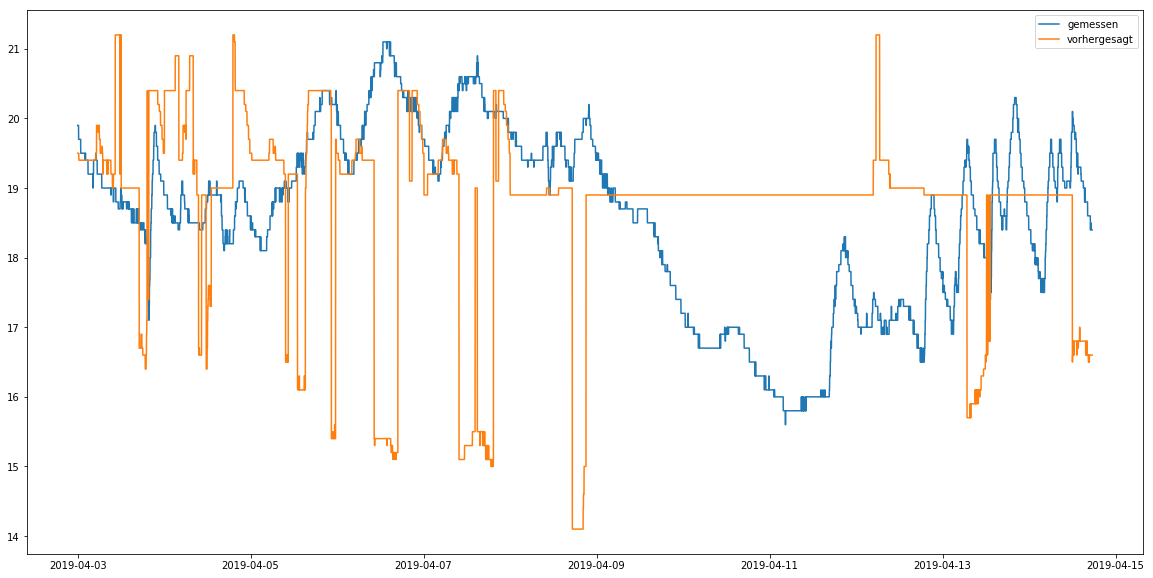

In [488]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_dtr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [489]:
from sklearn.ensemble import RandomForestRegressor

In [490]:
error_train = []
error_val = []

for i in range(1, 50):
    #for j in range(1,5):
        #for k in range(2,10):
    d_forest = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=42)
    d_forest.fit(X_train, y_train)
    y_pred_train = d_forest.predict(X_train)
    y_pred_val = d_forest.predict(X_val)
    error_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred_train))
    error_val.append(sklearn.metrics.mean_squared_error(y_val, y_pred_val))

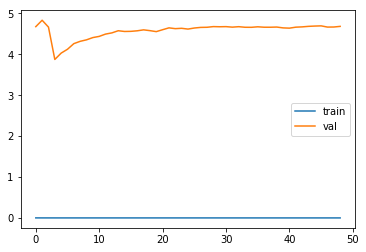

In [491]:
matplotlib.pyplot.plot(error_train)
matplotlib.pyplot.plot(error_val)
matplotlib.pyplot.legend(['train','val']);

In [496]:
fr = RandomForestRegressor(n_estimators=3, n_jobs=-1)
fr.fit(X_train, y_train)
y_fr_predict = fr.predict(frame4)

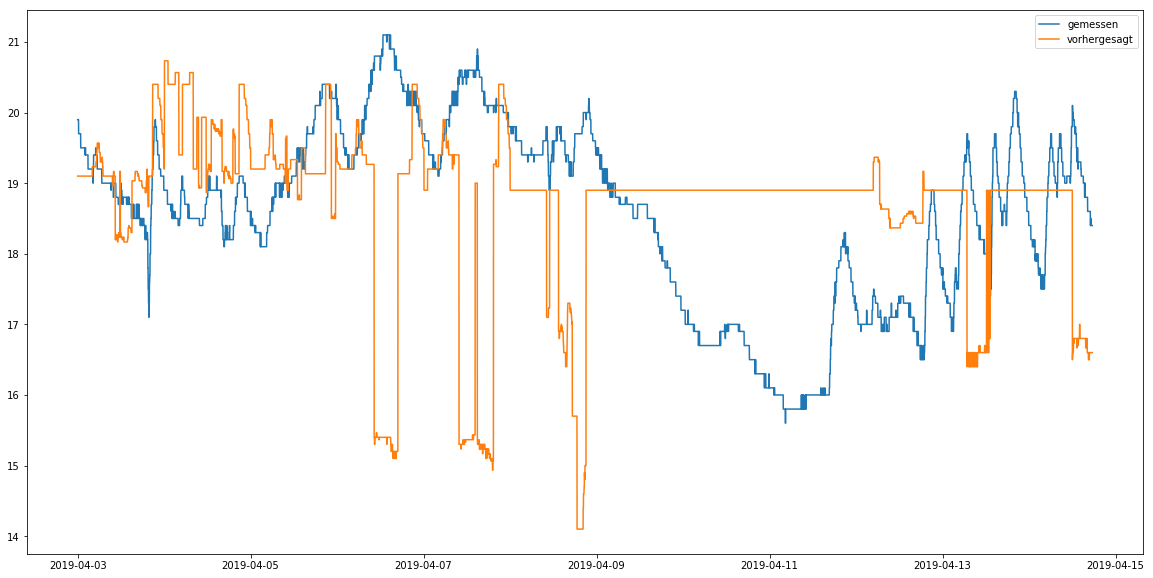

In [497]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_fr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [498]:
(y_fr_predict-frame3['current_temp']).mean()

0.11209125175080879

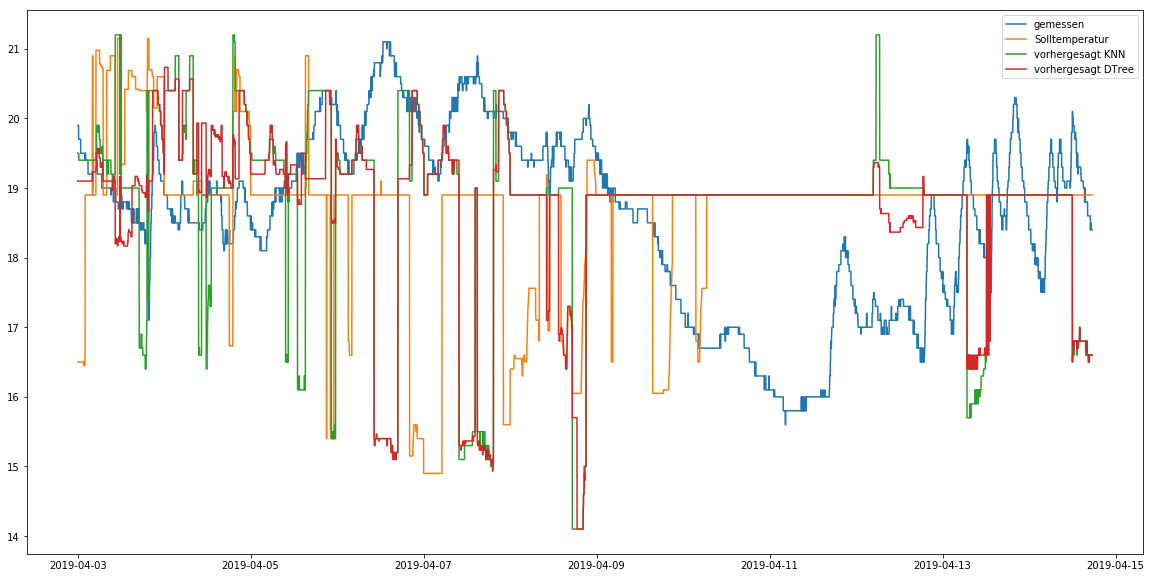

In [501]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
#matplotlib.pyplot.plot_date(dates, frame3['set_temp'], 'b-')
matplotlib.pyplot.plot_date(dates,y_k_predict.reshape(y_k_predict.shape[0]),'-')
matplotlib.pyplot.plot_date(dates,y_dtr_predict,'-')
matplotlib.pyplot.plot_date(dates,y_fr_predict,'-')
matplotlib.pyplot.legend(['gemessen', 'Solltemperatur', 'vorhergesagt KNN', 'vorhergesagt DTree', 'Random Forest']);